Trajectories for temperature 0.1 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.1.npy
Trajectories for temperature 0.2 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.2.npy
Trajectories for temperature 0.3 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.3.npy
Trajectories for temperature 0.4 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.4.npy
Trajectories for temperature 0.5 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.5.npy
Trajectories for temperature 0.6 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.6.npy
Trajectories for temperature 0.7 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_

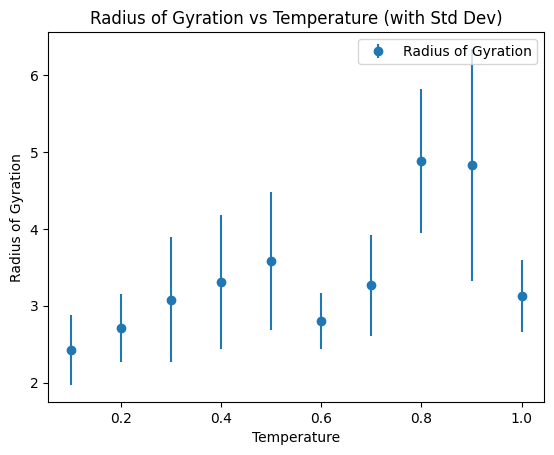

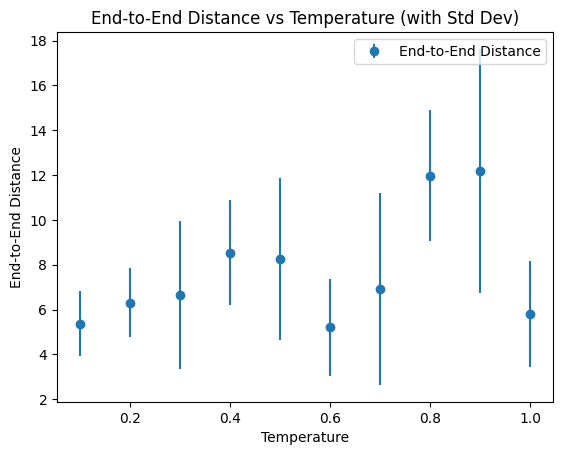

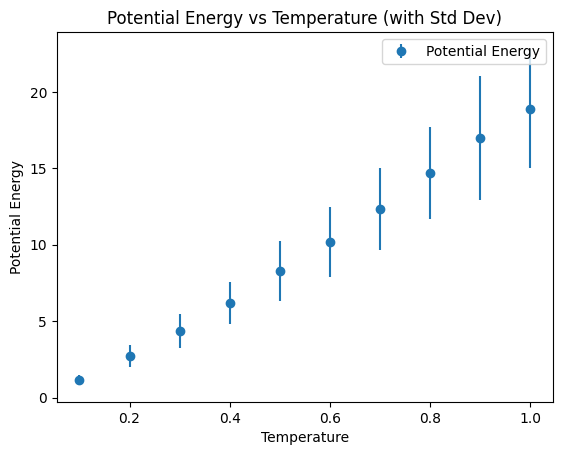

In [9]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Simulation parameters
dt = 0.01  # Time step
total_steps = 10000  # Number of steps per temperature
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Temperature range for the simulation
temperatures = np.linspace(0.1, 1.0, 10)

# Arrays to store results for different temperatures
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each temperature
for T in temperatures:
    target_temperature = T

    # Re-initialize positions and velocities
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties at each step for the current temperature
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Initialize an empty list to store trajectories for the current temperature
    trajectories = []

    # Run the simulation loop for the current temperature
    for step in range(total_steps):
        # Integrate equations of motion
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

        # Apply thermostat
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store the trajectory (current positions) at each time step
        trajectories.append(positions.copy())

        # Compute properties for each step
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(n_particles - 1):
            for j in range(i + 1, n_particles):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff:
                    if abs(i - j) == 2:
                        epsilon_value = epsilon_repulsive
                    elif abs(i - j) > 2:
                        epsilon_value = epsilon_attractive
                    else:
                        continue
                    E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store values for this step
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Convert trajectories to NumPy array
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current temperature
    trajectory_file_path = os.path.join(output_dir, f"trajectories_T_{T:.1f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for temperature {T:.1f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current temperature
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(temperatures, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature (with Std Dev)')
plt.legend()
plt.show()


Trajectories for temperature 0.1 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.1.npy
Trajectories for temperature 0.2 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.2.npy
Trajectories for temperature 0.3 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.3.npy
Trajectories for temperature 0.4 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.4.npy
Trajectories for temperature 0.5 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.5.npy
Trajectories for temperature 0.6 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.6.npy
Trajectories for temperature 0.7 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_

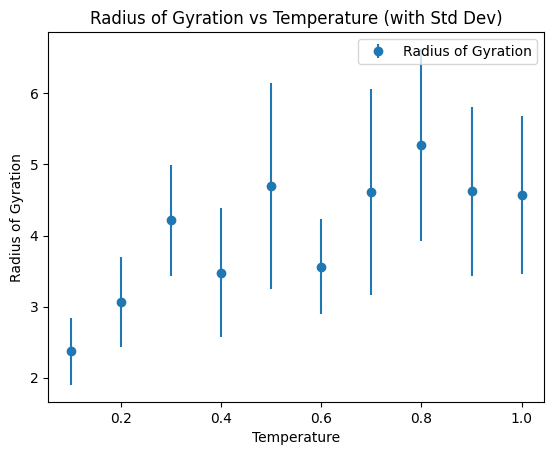

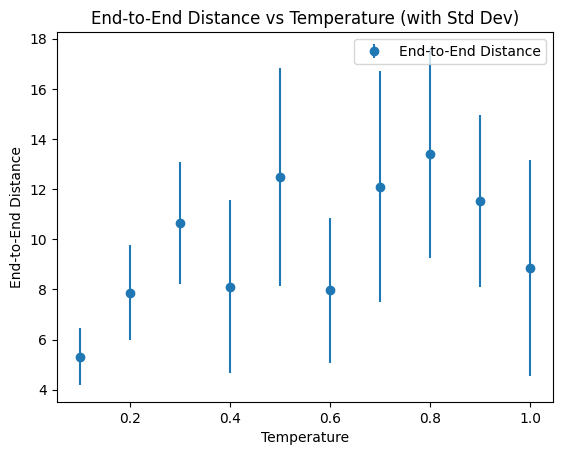

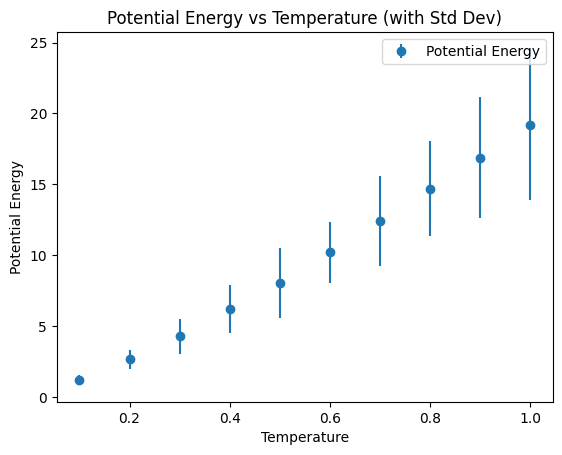

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Simulation parameters
dt = 0.01  # Time step
total_steps = 60000  # Number of steps per temperature
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Set random seed for reproducibility
np.random.seed(42)

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Temperature range for the simulation
temperatures = np.linspace(0.1, 1.0, 10)

# Arrays to store results for different temperatures
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each temperature
for T in temperatures:
    target_temperature = T

    # Re-initialize positions and velocities
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties at each step for the current temperature
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Initialize an empty list to store trajectories for the current temperature
    trajectories = []

    # Run the simulation loop for the current temperature
    for step in range(total_steps):
        # Integrate equations of motion
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass)

        # Apply thermostat
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store the trajectory (current positions) at each time step
        trajectories.append(positions.copy())

        # Compute properties for each step
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(n_particles - 1):
            for j in range(i + 1, n_particles):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff:
                    if abs(i - j) == 2:
                        epsilon_value = epsilon_repulsive
                    elif abs(i - j) > 2:
                        epsilon_value = epsilon_attractive
                    else:
                        continue
                    E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store values for this step
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Convert trajectories to NumPy array
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current temperature
    trajectory_file_path = os.path.join(output_dir, f"trajectories_T_{T:.1f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for temperature {T:.1f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current temperature
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(temperatures, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature (with Std Dev)')
plt.legend()
plt.show()


Trajectories for temperature 0.1 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.1.npy
Trajectories for temperature 0.2 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.2.npy
Trajectories for temperature 0.3 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.3.npy
Trajectories for temperature 0.4 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.4.npy
Trajectories for temperature 0.5 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.5.npy
Trajectories for temperature 0.6 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.6.npy
Trajectories for temperature 0.7 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_

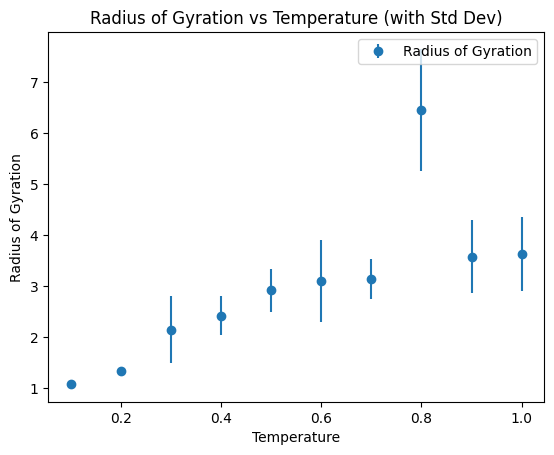

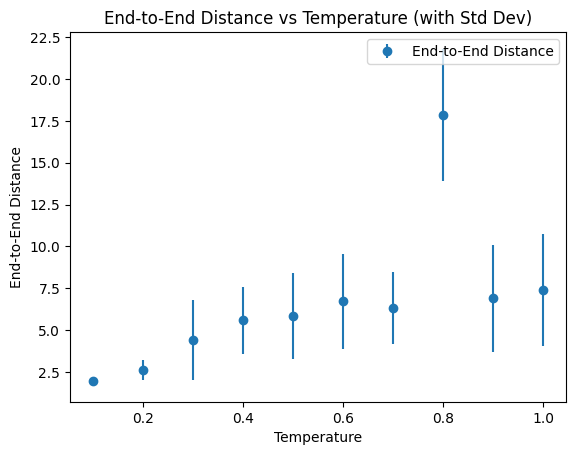

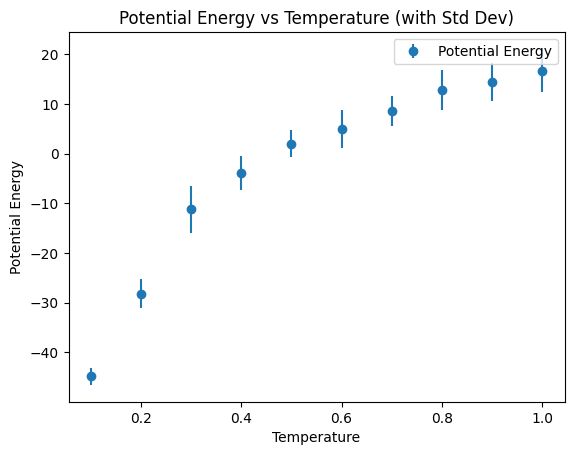

In [16]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
equilibration_steps = 40000  # Equilibration steps
sampling_steps = 10000  # At least 100 sampling points
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities with ASE Atoms
def initialize_chain_ase(n_particles, box_size, r0):
    """Initialize polymer chain positions with ASE."""
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]

    # Create ASE Atoms object
    polymer_chain = Atoms(positions=positions, symbols='C' * n_particles, cell=[box_size, box_size, box_size], pbc=True)
    return polymer_chain

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        if distance != 0:
            force_magnitude = -k * (distance - r0)
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        for j in range(i + 1, len(positions)):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff or distance == 0:
                continue  # Ignore interactions beyond the cutoff or zero distance
            if abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, box_size):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size)
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (len(velocities) * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Temperature range for the simulation
temperatures = np.linspace(0.1, 1.0, 10)

# Arrays to store results for different temperatures
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each temperature
for T in temperatures:
    target_temperature = T

    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current temperature
    trajectory_file_path = os.path.join(output_dir, f"trajectories_T_{T:.1f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for temperature {T:.1f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current temperature
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(temperatures, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature (with Std Dev)')
plt.legend()
plt.show()


In [ ]:
# Print results for Radius of Gyration
print("Temperature vs Radius of Gyration")
print(f"{'Temperature':>12} {'Mean Rg':>10} {'Std Rg':>10} {'Rg (Step 50000)':>18}")
for T, mean_Rg, std_Rg, Rg_50000 in zip(temperatures, mean_Rg_values, std_Rg_values, Rg_step50000):
    print(f"{T:12.4f} {mean_Rg:10.4f} {std_Rg:10.4f} {Rg_50000:18.4f}")

print("\nTemperature vs End-to-End Distance")
print(f"{'Temperature':>12} {'Mean Ree':>10} {'Std Ree':>10} {'Ree (Step 50000)':>18}")
for T, mean_Ree, std_Ree, Ree_50000 in zip(temperatures, mean_Ree_values, std_Ree_values, Ree_step50000):
    print(f"{T:12.4f} {mean_Ree:10.4f} {std_Ree:10.4f} {Ree_50000:18.4f}")

print("\nTemperature vs Potential Energy")
print(f"{'Temperature':>12} {'Mean PE':>10} {'Std PE':>10} {'PE (Step 50000)':>18}")
for T, mean_PE, std_PE, PE_50000 in zip(temperatures, mean_potential_energies, std_potential_energies, energy_step50000):
    print(f"{T:12.4f} {mean_PE:10.4f} {std_PE:10.4f} {PE_50000:18.4f}")


Temperature vs Radius of Gyration
 Temperature    Mean Rg     Std Rg    Rg (Step 50000)
      0.1000     1.0857     0.0231             3.1601
      0.2000     1.3293     0.0863             5.0832
      0.3000     2.1457     0.6566             7.9774
      0.4000     2.4216     0.3793             4.4881
      0.5000     2.9163     0.4218             7.1256
      0.6000     3.1038     0.8037             5.2039
      0.7000     3.1417     0.3946             7.4660
      0.8000     6.4552     1.1940            10.3773
      0.9000     3.5771     0.7191             6.2835
      1.0000     3.6324     0.7244             6.9028

Temperature vs End-to-End Distance
 Temperature   Mean Ree    Std Ree   Ree (Step 50000)
      0.1000     1.9623     0.2297             6.1074
      0.2000     2.6503     0.5995            10.2965
      0.3000     4.4181     2.3684            23.7892
      0.4000     5.5940     2.0084            11.4021
      0.5000     5.8365     2.5571            20.3001
      0.6000

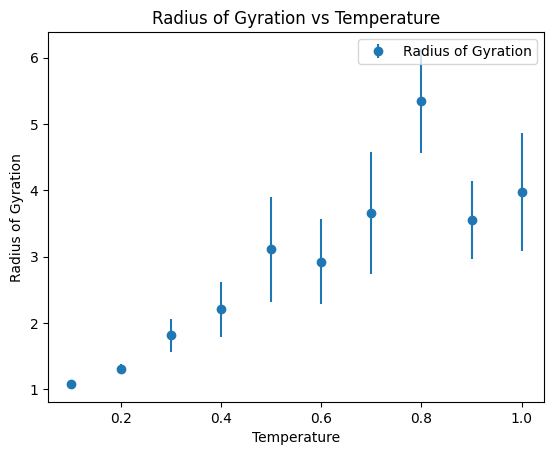

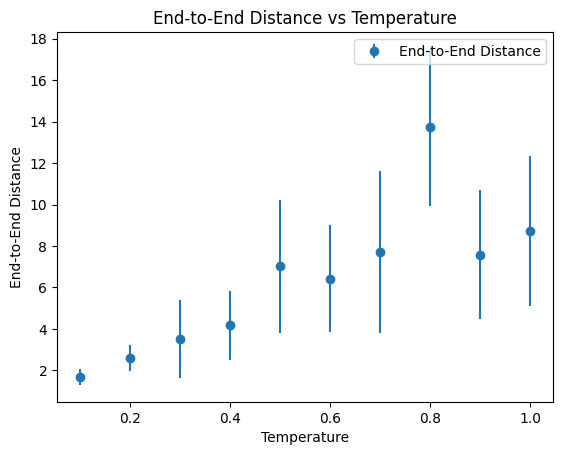

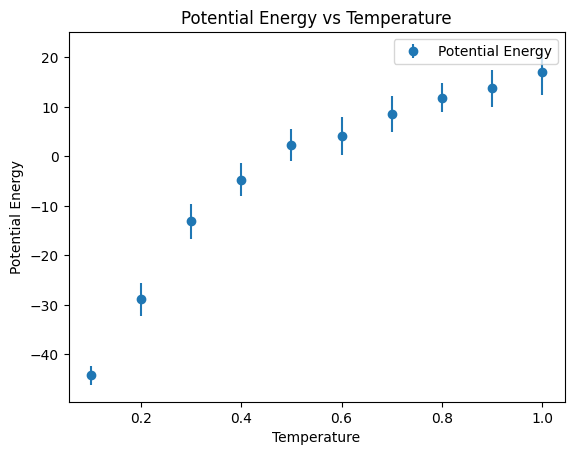

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
import os

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
equilibration_steps = 40000  # Equilibration steps
sampling_steps = 10000  # Sampling steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Directory to store trajectories
output_dir = "trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities
def initialize_chain_ase(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    polymer_chain = Atoms(positions=positions, symbols='C' * n_particles, cell=[box_size, box_size, box_size], pbc=True)
    return polymer_chain

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        if distance != 0:
            force_magnitude = -k * (distance - r0)
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[i + 1] += force
    return forces

# Lennard-Jones Forces (Separate for Repulsive and Attractive)
def compute_lj_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        for j in range(i + 1, len(positions)):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff or distance == 0:
                continue
            
            # Determine interaction type
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon
            else:
                continue
            
            force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, dt, mass, box_size, k, r0, epsilon_repulsive, epsilon_attractive, sigma):
    # Compute forces separately
    forces_harmonic = compute_harmonic_forces(positions, k, r0, box_size)
    forces_repulsive = compute_lj_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive')
    forces_attractive = compute_lj_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    
    total_forces = forces_harmonic + forces_repulsive + forces_attractive

    # Velocity Verlet Integration
    velocities += 0.5 * total_forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    
    # Recompute forces after position update
    forces_harmonic = compute_harmonic_forces(positions, k, r0, box_size)
    forces_repulsive = compute_lj_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive')
    forces_attractive = compute_lj_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    total_forces = forces_harmonic + forces_repulsive + forces_attractive
    velocities += 0.5 * total_forces / mass * dt

    return positions, velocities, forces_harmonic, forces_repulsive, forces_attractive

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (len(velocities) * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    return np.sqrt(Rg_squared)

def calculate_end_to_end_distance(positions):
    return np.linalg.norm(positions[-1] - positions[0])

# Temperature range for the simulation
temperatures = np.linspace(0.1, 1.0, 10)

# Arrays to store results for different temperatures
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Main Loop
for T in temperatures:
    target_temperature = T

    # Initialize positions and velocities
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces_harmonic, forces_repulsive, forces_attractive = velocity_verlet(
            positions, velocities, dt, mass, box_size, k, r0, epsilon_repulsive, epsilon_attractive, sigma
        )
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []

    for step in range(sampling_steps):
        positions, velocities, forces_harmonic, forces_repulsive, forces_attractive = velocity_verlet(
            positions, velocities, dt, mass, box_size, k, r0, epsilon_repulsive, epsilon_attractive, sigma
        )
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_repulsive = 0.0
        E_attractive = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                    E_repulsive += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                    E_attractive += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        total_potential_energy = E_harmonic + E_repulsive + E_attractive
        potential_energies.append(total_potential_energy)

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)

    # Store statistics
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))
    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))
    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plot results
plt.figure()
plt.errorbar(temperatures, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature')
plt.legend()
plt.show()


Trajectories for temperature 0.10 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.10.npy
Trajectories for temperature 0.15 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.15.npy
Trajectories for temperature 0.20 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.20.npy
Trajectories for temperature 0.25 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.25.npy
Trajectories for temperature 0.30 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.30.npy
Trajectories for temperature 0.35 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_T_0.35.npy
Trajectories for temperature 0.40 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\tr

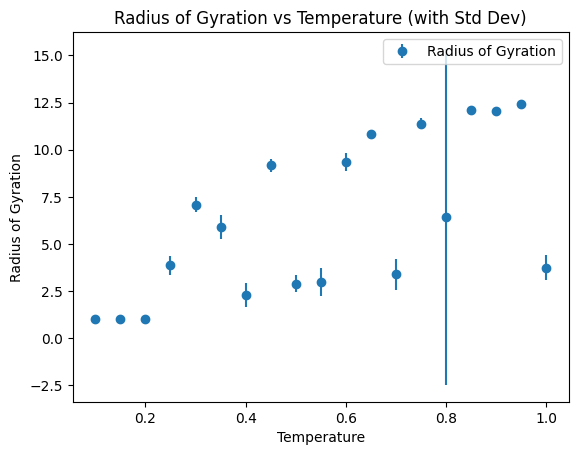

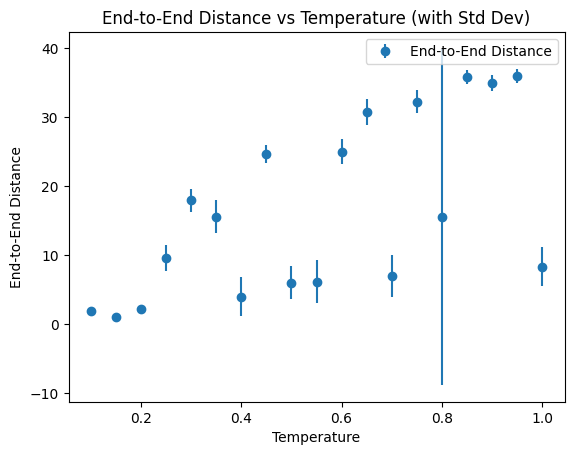

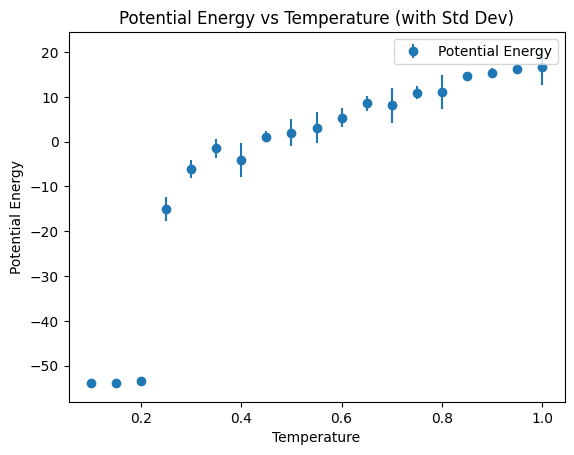

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
equilibration_steps = 140000  # Equilibration steps
sampling_steps = 10000  # At least 100 sampling points
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities with ASE Atoms
def initialize_chain_ase(n_particles, box_size, r0):
    """Initialize polymer chain positions with ASE."""
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]

    # Create ASE Atoms object
    polymer_chain = Atoms(positions=positions, symbols='C' * n_particles, cell=[box_size, box_size, box_size], pbc=True)
    return polymer_chain

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        if distance != 0:
            force_magnitude = -k * (distance - r0)
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        for j in range(i + 1, len(positions)):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff or distance == 0:
                continue  # Ignore interactions beyond the cutoff or zero distance
            if abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, box_size):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size)
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (len(velocities) * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Temperature range for the simulation
temperatures = np.linspace(0.1, 1.0, 19)

# Arrays to store results for different temperatures
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each temperature
for T in temperatures:
    target_temperature = T

    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current temperature
    trajectory_file_path = os.path.join(output_dir, f"trajectories_T_{T:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for temperature {T:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current temperature
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(temperatures, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature (with Std Dev)')
plt.legend()
plt.show()


In [6]:
# Print results for Radius of Gyration
print("Temperature vs Radius of Gyration")
print(f"{'Temperature':>12} {'Mean Rg':>12} {'Std Rg':>12}")
for T, mean_Rg, std_Rg in zip(temperatures, mean_Rg_values, std_Rg_values):
    print(f"{T:12.4f} {mean_Rg:12.4f} {std_Rg:12.4f}")

# Print results for End-to-End Distance
print("\nTemperature vs End-to-End Distance")
print(f"{'Temperature':>12} {'Mean Ree':>12} {'Std Ree':>12}")
for T, mean_Ree, std_Ree in zip(temperatures, mean_Ree_values, std_Ree_values):
    print(f"{T:12.4f} {mean_Ree:12.4f} {std_Ree:12.4f}")

# Print results for Potential Energy
print("\nTemperature vs Potential Energy")
print(f"{'Temperature':>12} {'Mean PE':>12} {'Std PE':>12}")
for T, mean_PE, std_PE in zip(temperatures, mean_potential_energies, std_potential_energies):
    print(f"{T:12.4f} {mean_PE:12.4f} {std_PE:12.4f}")


Temperature vs Radius of Gyration
 Temperature      Mean Rg       Std Rg
      0.1000       1.0857       0.0231
      0.1500       1.1719       0.0370
      0.2000       1.3574       0.1051
      0.2500       1.5469       0.1186
      0.3000       1.9583       0.3577
      0.3500       1.9539       0.2234
      0.4000       2.5409       0.5522
      0.4500       3.3472       1.1913
      0.5000       2.7060       0.5007
      0.5500       2.7132       0.4565
      0.6000       3.6416       1.1458
      0.6500       3.4073       0.7045
      0.7000       3.6691       2.5479
      0.7500       3.9164       0.4365
      0.8000       3.7076       1.9715
      0.8500       4.6126       1.0404
      0.9000       3.8613       0.7112
      0.9500       3.8741       0.9695
      1.0000       4.0336       0.8468

Temperature vs End-to-End Distance
 Temperature     Mean Ree      Std Ree
      0.1000       1.9623       0.2297
      0.1500       1.6811       0.4383
      0.2000       2.6378       0

Trajectories for temperatures 0.10 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Temp_0.10.npy
Trajectories for temperatures 0.15 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Temp_0.15.npy
Trajectories for temperatures 0.20 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Temp_0.20.npy
Trajectories for temperatures 0.25 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Temp_0.25.npy
Trajectories for temperatures 0.30 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Temp_0.30.npy
Trajectories for temperatures 0.35 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Temp_0.35.npy
Trajectories for temperatures 0.40 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project

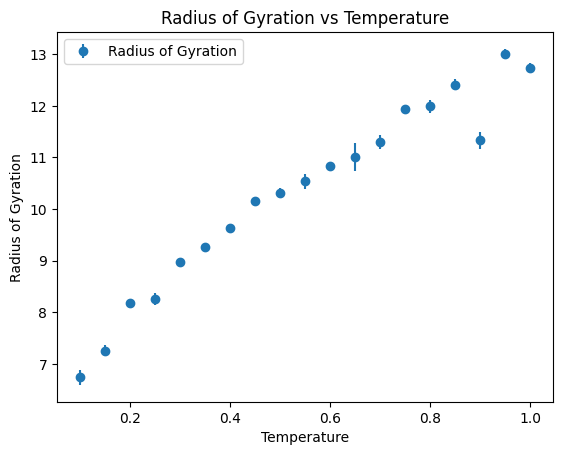

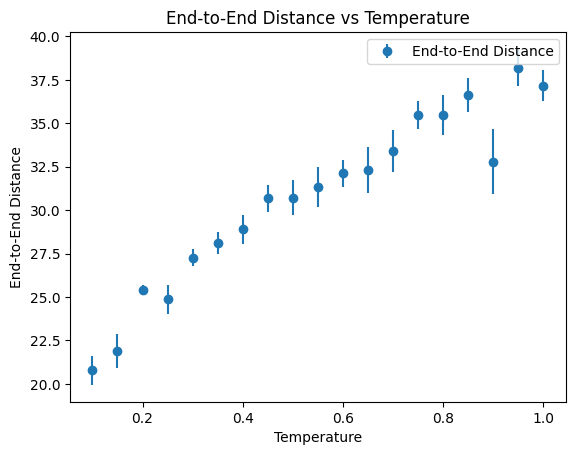

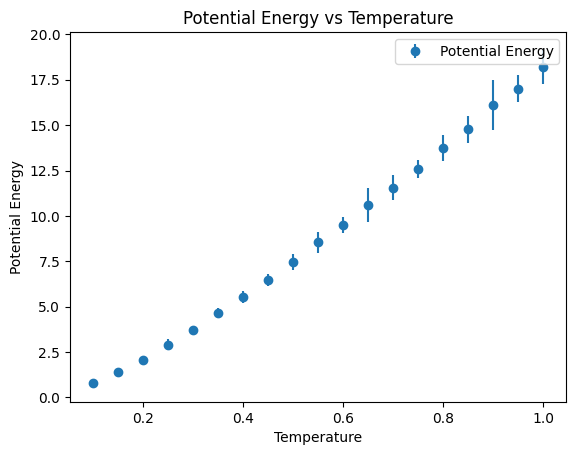

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
k = 1
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different temperatures
temperatures = np.linspace(0.1, 1.0, 19)  # Vary temperature from 0.1 to 1.0
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for T in temperatures:
    target_temperature = T  # Set current temperature

    # Re-initialize positions and velocities for each temperature
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store results for different temperatures
temperatures = np.linspace(0.1, 1.0, 19)  # Vary temperature from 0.1 to 1.0
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for T in temperatures:
    target_temperature = T  # Set current temperature

    # Re-initialize positions and velocities for each temperature
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 140,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []  # Initialize an empty list to store the trajectory

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, r0)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store positions for the trajectory
        trajectories.append(positions.copy())  # Save a copy of the current positions

        # Store values only after step 140,000
        if step >= 140000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            # Lennard-Jones Potentials
            def lj_repulsive_potential(r, epsilon, sigma):
                if r < 2**(1/6) * sigma:
                    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6 + 0.25)
                return 0.0

            def lj_attractive_potential(r, epsilon, sigma):
                return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            E_LJ += lj_repulsive_potential(distance, epsilon_repulsive, sigma)
                        elif abs(i - j) > 2:
                            E_LJ += lj_attractive_potential(distance, epsilon_attractive, sigma)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Save the trajectory data for the current temperature
    trajectories = np.array(trajectories)  # Convert trajectory list to NumPy array
    trajectory_file_path = os.path.join("output", f"trajectories_Temp_{T:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for temperature {T:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for each property
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))


# Plotting the results with error bars
plt.figure()
plt.errorbar(temperatures, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature')
plt.legend()
plt.show()



In [16]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
k = 1
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 100  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different temperatures
temperatures = np.linspace(0.1, 1.0, 10)  # Vary temperature from 0.1 to 1.0
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for T in temperatures:
    target_temperature = T  # Set current temperature

    # Re-initialize positions and velocities for each temperature
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 140,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, r0)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 140,000
        if step >= 140000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            # Lennard-Jones Potentials
            # Revised functions for repulsive and attractive LJ potentials
            def lj_repulsive_potential(r, epsilon, sigma):
                if r < 2**(1/6) * sigma:
                    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6 + 0.25)
                return 0.0

            def lj_attractive_potential(r, epsilon, sigma):
                return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            # Repulsive Lennard-Jones Potential
                            E_LJ += lj_repulsive_potential(distance, epsilon_repulsive, sigma)
                        elif abs(i - j) > 2:
                            # Attractive Lennard-Jones Potential
                            E_LJ += lj_attractive_potential(distance, epsilon_attractive, sigma)

            potential_energy = E_harmonic + E_LJ
            
            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current temperature
    trajectory_file_path = os.path.join(output_dir, f"trajectories_Temp_{T:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for temperatures {T:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for each property
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(temperatures, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(temperatures, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature')
plt.legend()
plt.show()



KeyboardInterrupt: 